# Transcriptomics Sprint

**Goal**: Train a simple regression model on ESM1b embeddings. 
 1. Load the data. 
 2. Run data through ESM model. 
 3. Cache representations to disk. 
 4. Train sklearn classifier on mean.

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm 

import torch
import esm

In [27]:
data_path = 'RegSeq_100_genes_data/'
fname = 'araCAnaerodataset_alldone_with_large'

df = pd.read_fwf(os.path.join(data_path, fname))

# rename column 'ct' -> 'count' 
df = df.rename(columns={'ct_0':'dna_count'})
df = df.rename(columns={'ct_1':'rna_count'})

df

,ct,dna_count,rna_count,seq
0,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
1,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
2,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
3,5.0,5.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
4,1.0,1.0,0.0,AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGG...
...,...,...,...,...
6597,20.0,5.0,15.0,TTGTGATGGATAAATATGCGTTGGCAAAGCACAGTGAGACTCGGTG...
6598,2.0,0.0,2.0,TTGTGATGGATAAATATGCGTTGGCAAAGCACAGTGAGACTCGGTG...
6599,27.0,1.0,26.0,TTGTGATGGATAAATATGCGTTGGCAAAGCACAGTGAGACTCGGTG...
6600,12.0,0.0,12.0,TTGTGATGGATAAATATGCGTTGGCAAAGCACAGTGAGACTCGGTG...


Text(0, 0.5, 'Frequency')

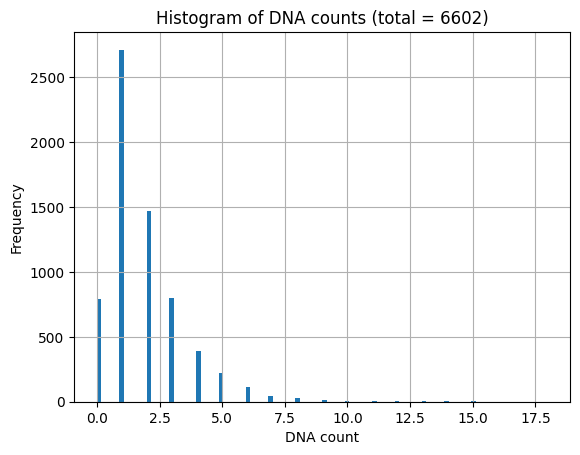

In [28]:
# histogram of dna_count 
df['dna_count'].hist(bins=100)
# title 
plt.title(f'Histogram of DNA counts (total = {len(df)})')
# x-axis label
plt.xlabel('DNA count')
# y-axis label
plt.ylabel('Frequency')

Let's remove the rows with zero DNA count. 

Text(0, 0.5, 'Frequency')

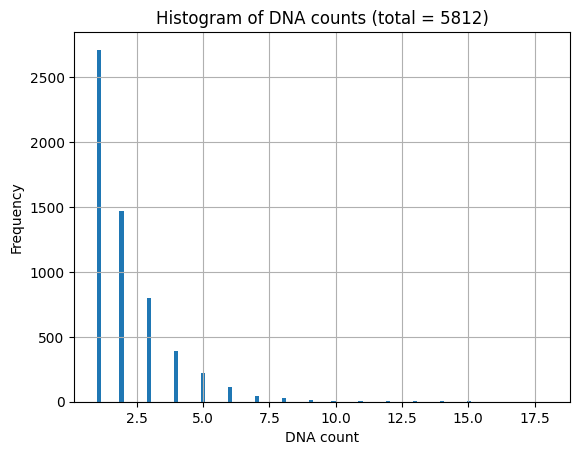

In [29]:
df = df[df['dna_count'] > 0]
# reset index
df = df.reset_index(drop=True)

# new histogram
df['dna_count'].hist(bins=100)
# title
plt.title(f'Histogram of DNA counts (total = {len(df)})')
# x-axis label
plt.xlabel('DNA count')
# y-axis label
plt.ylabel('Frequency')

## 2: Run the Data thru ESM Model

In [42]:
# %%  Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# model.to('mps')

print("Model device: ", next(model.parameters()).device)

Model device:  cpu


In [43]:
# Format the data for use in ESM 
# iterate thru rows of df 
data_list = []

for index, row in df.iterrows():
    # get dna sequence 
    seq = row['seq']
    # convert to uppercase 
    seq = seq.upper()
    tup = (f'prot{index}', seq)
    data_list.append(tup)



batch_labels, batch_strs, batch_tokens = batch_converter(data_list)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

print("Length of data_list: ", len(data_list)) 
print("\n\nFirst 3 elements: ")
data_list[:3]

Length of data_list:  5812


First 3 elements: 


[('prot0',
  'AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGGCAAAAAATCGATGGGGACTCTTCTGCCGGGATTATCGACACTTTTGTTACGCGTTTTTGTCATGGTTTTGGTGCCGCTTCGGTACAGAATGCTTTTAATAAGCGGGGTTACTGGAAGATCTCCCGTAGGCTTGA'),
 ('prot1',
  'AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGGCAAAAAATCGATGGGGACTCTTCTGCCGGGATTATCGACACTTTTGTTACGCGTTTTTGTCATGGTTTTGGTGCCGCTTCGGTACAGAATGCTTTTAATAAGCGGGGTTACTGGATCCGAAACGTCCCAGGTTT'),
 ('prot2',
  'AAATTATGGATAAAAATGGTATGGCATAGCAAAGTGAGACGGCTGGCAAAAAATCGATGGGGACTCTTCTGCCGGGATTATCGACACTTTTGTTACGCGTTTTTGTCATGGTTTTGGTGCCGCTTCGGTACAGAATGCTTTTAATAAGCGGGGTTACTGGCTAACAAGCGACGCCACGGA')]

Let's run the sequences through the model! 

We will use a batch size of 10 so we don't destroy our computer :)

In [46]:
# %% Extract per-residue representations (on CPU)
batch_size = 1
results_list = []

# iterate thru data_list in batches
for batch_idx in tqdm(range(0, len(data_list), batch_size)):
    batch_tokens_ = batch_tokens[batch_idx:batch_idx+batch_size]
    batch_labels_ = batch_labels[batch_idx:batch_idx+batch_size]
    with torch.no_grad():
        results = model(batch_tokens_, repr_layers=[33], return_contacts=True)
    token_representations_ = results["representations"][33]
    results_list.append(token_representations_)

  0%|          | 21/5812 [00:12<58:20,  1.65it/s]


In [54]:
results_list[1].shape
token_representations = torch.cat(results_list, dim=0)
token_representations.shape

# cache to disk 
torch.save(token_representations, f'token_representations_{token_representations.shape[0]}.pt')

In [10]:
# %% Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []

for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

In [12]:
sequence_representations[0].shape

torch.Size([1280])

# Performing regression

Let's try to predict the normalized mRNA count (i.e., `mrna_count / dna_count`)

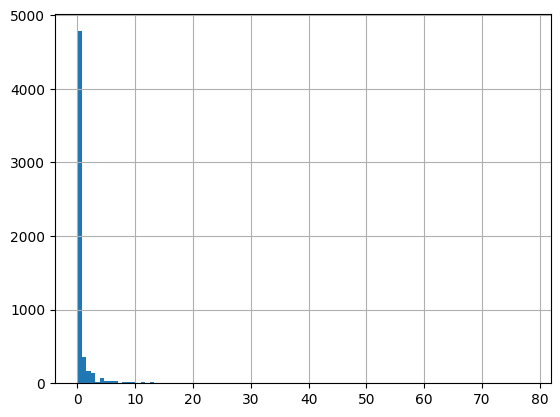

In [17]:
df['normalized_rna_count'] = df['rna_count'] / df['dna_count']
# histogram of normalized
df['normalized_rna_count'].hist(bins=100)

num_sequences = len(sequence_representations)

label_column = df['normalized_rna_count'].tolist()[:num_sequences]
label_column = np.array(label_column)

In [19]:
# convert sequence representations to numpy array
sequence_representations = [np.array(x) for x in sequence_representations]
sequence_representations = np.array(sequence_representations)

# print shape 
print("Sequence representations shape: ", sequence_representations.shape)

Sequence representations shape:  (22, 1280)


In [21]:
# train linear regression model from sequence_oredictions to label_column
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequence_representations, label_column, test_size=0.25, random_state=42)

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)

# r^2 on test set 
r2 = model.score(X_test, y_test)
print("r^2 on test set: ", r2)

# r^2 on train set
r2 = model.score(X_train, y_train)
print("r^2 on train set: ", r2)

r^2 on test set:  -1.4460279208098652
r^2 on train set:  0.9999999999968177
